
### Лабораторная 2

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Пункт 1
- Использовать линейную нейронную сеть с задержками для аппроксимации функции.

In [2]:
# Функции
def fun_x_1(t):

    return np.sin(t*t)

def fun_x_2(t):

    return np.sin((2*np.pi*t)/3)

def fun_y(t):

    return 0.2 * np.sin(((2*np.pi*t)/3)+(np.pi/2))


# Пространства
t_1 = np.arange(0, 5, 0.025)
t_2 = np.arange(0, 5, 0.025)

x_1 = torch.tensor(fun_x_1(t_1))
x_2 = torch.tensor(fun_x_2(t_2))
y_1 = fun_y(t_1)
y_2 = fun_y(t_2)

In [3]:
# Пространства
t_1 = np.arange(0, 5, 0.025)
t_2 = np.arange(0, 5, 0.025)

x_1 = torch.tensor(fun_x_1(t_1))
x_2 = torch.tensor(fun_x_2(t_2))
y_1 = fun_y(t_1)
y_2 = fun_y(t_2)

In [4]:
# Сеть
class Net(nn.Module):
    def __init__(self,D):
        super().__init__()
        self.fc1 = nn.Linear(D, 1)

    def forward(self, x):

        return self.fc1(x)



# Подготовка выборки
def prepare_sample(x, y, D, ):
    back_x = []
    back_y = []


    x = [0 for i in range(D)] + list(x)
    y = [0 for i in range(D)] + list(y)


    for i in range(0,len(x)-D,1):

        back_x.append(x[i:i+D])
        back_y.append(y[i+D])

    back_x = torch.tensor(back_x)
    return back_x, back_y


# Обучение через псевдоинверсивное правило
def train_model_psevda(x_first, y_second, D):
    x, y = prepare_sample(x_first, y_second, D)

    x = list(np.array(x))

    y = np.array(y)
    for i in range(len(x)):
        x[i] = [1] + list(x[i])
    x = np.array(x)

    W = np.dot(y,np.linalg.pinv(x.T))
    model = Net(D=D)
    dict_of_weights = model.state_dict()

    dict_of_weights['fc1.weight'] = torch.tensor(W[1:]).reshape((1,D))

    dict_of_weights['fc1.bias'] = torch.tensor([W[0]])
    model.load_state_dict(dict_of_weights, strict=False)
    x, _ = prepare_sample(x_first, x_first, D)
    x = np.array(x)
    prediction = model(torch.tensor(x).float()).detach().numpy()
    return model, np.sqrt(mean_squared_error(y,prediction)) ,prediction, x, y

# Правило Уидроу-Хоффа
def train_model_Hoffe(x, y, D,  lr=0.01,  epochs = 50):
    model = Net(D=D)
    x, y = prepare_sample(x, y, D)



    error = 0
    history = {}
    prediction = []
    for i in range(epochs):


        for k,z in zip(x,y):

            error = z - model(k.float())
            dict_of_weights = model.state_dict()
            dict_of_weights['fc1.weight'] = dict_of_weights['fc1.weight'] + lr * error *(k.float()).T
            dict_of_weights['fc1.bias'] = dict_of_weights['fc1.bias'] + lr*error
            model.load_state_dict(dict_of_weights, strict=False)

            if i == epochs-1:

                prediction.append(float(model(k.float())))








    final_error = np.sqrt(mean_squared_error(y,prediction))

    return model, final_error, prediction, x, y


In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [6]:
# Метрики
def metrics(true, pred):

    true = np.array(true)
    pred = np.array(pred)

    print('r2_score = ', r2_score(true, pred))
    print('mean_squared_error = ', mean_squared_error(true, pred))
    print('RMSE = ', np.sqrt(mean_squared_error(true, pred)))
    print('Относительная СКО = ', np.std(true - pred))
    print('mean_absolute_error = ', mean_absolute_error(true, pred))
    print('min absolute error = ', min(abs(true - pred)))
    print('max absolute error = ', max(abs(true - pred)))





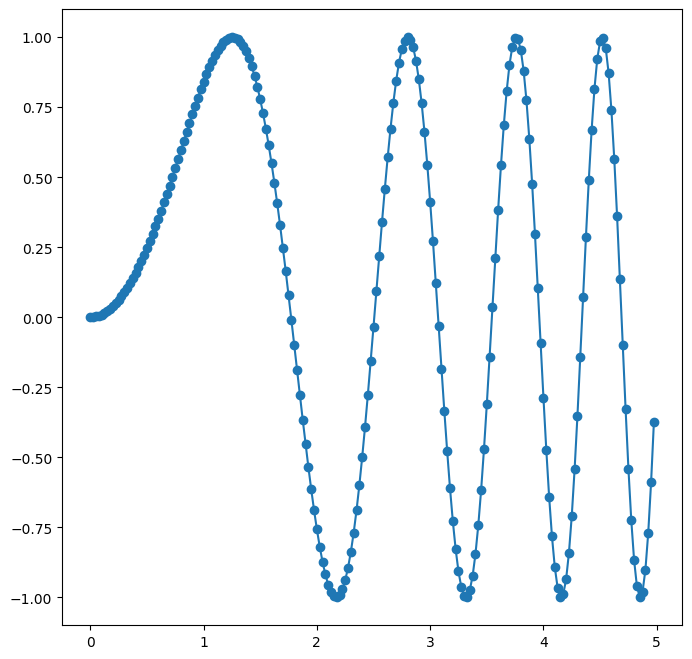

In [7]:
# Псевдоинверсное правило
model, error_psevdo, pred, x, y = train_model_psevda(x_1, x_1, 5)
plt.figure(figsize=(8,8))
plt.scatter(t_1,pred)
plt.plot(t_1,y)


In [8]:
metrics(y, pred.reshape(-1))

r2_score =  0.9999999823866161
mean_squared_error =  7.850942335350356e-09
RMSE =  8.86055434797979e-05
Относительная СКО =  8.860553588922176e-05
mean_absolute_error =  3.622714777637865e-05
min absolute error =  1.44979345417795e-07
max absolute error =  0.0006220929964190494


In [9]:
print('Ошибка при псевдоинверсном правиле обучения', error_psevdo)

Ошибка при псевдоинверсном правиле обучения 8.86055434797979e-05


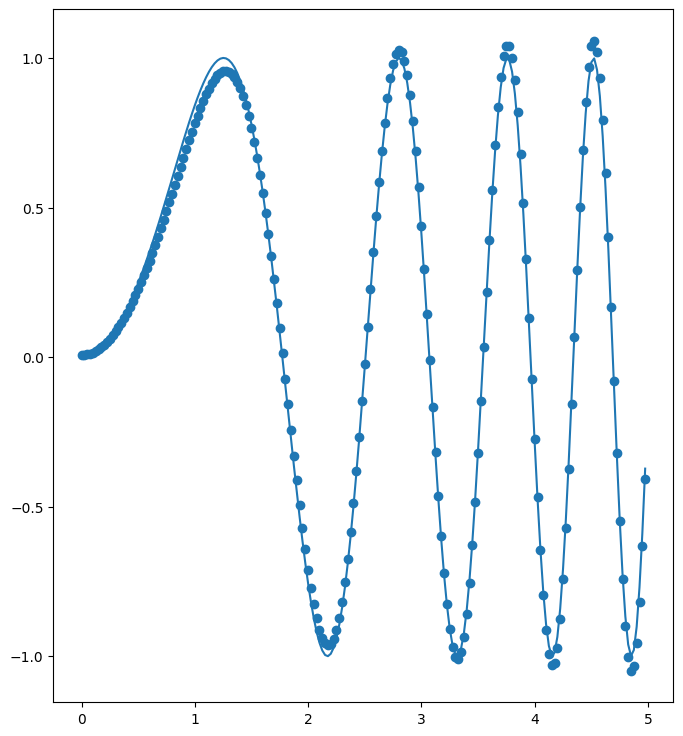

In [10]:
# Правило Правило Уидроу-Хоффа
model, error_hebb ,pred, x, y= train_model_Hoffe(x_1, x_1, 5,lr=0.01,epochs=50)
plt.figure(figsize=(8,9))
plt.scatter(t_1,pred)
plt.plot(t_1,y)


In [11]:
metrics(y, pred)

r2_score =  0.9977469766904451
mean_squared_error =  0.001004256550373738
RMSE =  0.03169000710592754
Относительная СКО =  0.03168998013047517
mean_absolute_error =  0.02655714409740438
min absolute error =  0.0004214981537090587
max absolute error =  0.06061163594461849


###### Псевдоинверсное правило показало себя лучше по метрикам, потому что применение данного правила дает результат близкий к аналитическому решению

### Пункт 2
- Использовать линейную нейронную сеть с задержками для аппроксимации функции и выполнения многошагового прогноза.

In [12]:
# Функция для подготовки выборки
def prepare_sample(x, y, D, ):
    back_x = []
    back_y = []


    x = [0 for i in range(D)] + list(x)
    y = [0 for i in range(D)] + list(y)


    for i in range(0,len(x)-D-1,1):

        back_x.append(x[i:i+D])
        back_y.append(y[i+D+1])

    back_x = torch.tensor(back_x)
    return back_x, back_y


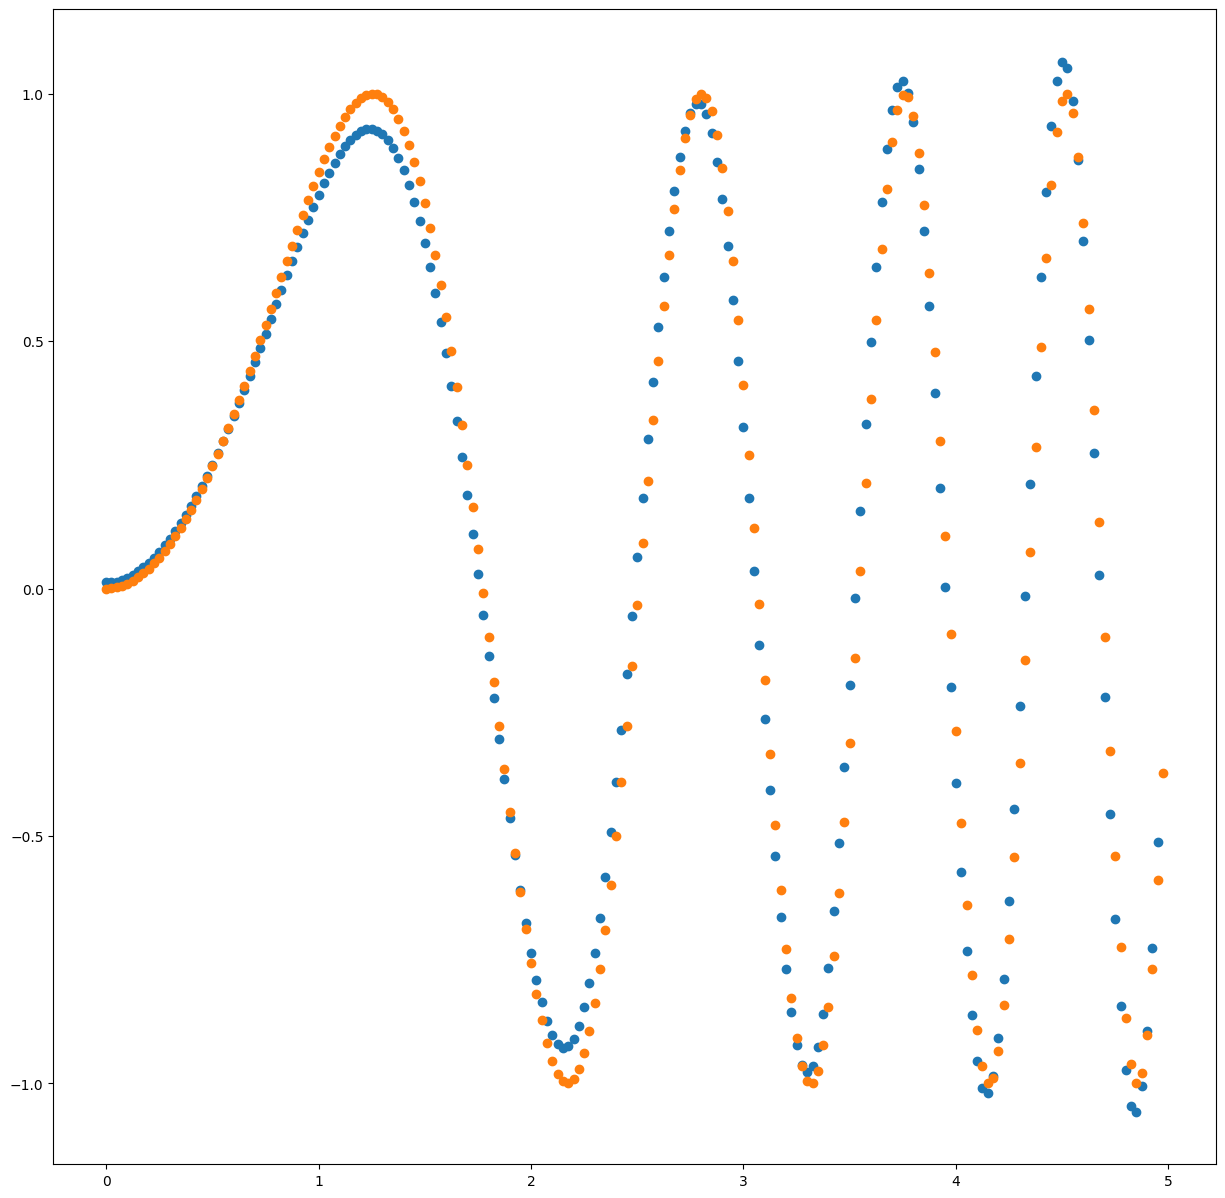

In [13]:
# Правило Правило Уидроу-Хоффа

# Функции
def fun_x_1(t):

    return np.sin(t*t)

def fun_x_2(t):

    return np.sin((2*np.pi*t)/3)

def fun_y(t):

    return 0.2 * np.sin(((2*np.pi*t)/3)+(np.pi/2))


# Пространства
t_1 = np.arange(0, 5, 0.025)
t_2 = np.arange(0, 5, 0.025)

x_1 = torch.tensor(fun_x_1(t_1))
x_2 = torch.tensor(fun_x_2(t_2))
y_1 = fun_y(t_1)
y_2 = fun_y(t_2)

model, error_hebb ,pred, x, y= train_model_Hoffe(x_1, x_1, 3,lr=0.001,epochs=600)
plt.figure(figsize=(15,15))
plt.scatter(t_1[:-1],pred)
plt.scatter(t_1,x_1)


In [14]:
# Веса и смещение
model.state_dict()

OrderedDict([('fc1.weight', tensor([[-0.9886,  0.3176,  1.5701]])),
             ('fc1.bias', tensor([0.0125]))])

In [15]:
def get_prediction(model, number, x, D):
    x, y = prepare_sample(x, x ,D)
    learning_part = list(x[-1])
    learning_part = [float(i) for i in learning_part]
    prediction = []

    for i in range(number):

        prediction.append(model(torch.tensor(learning_part)).detach().numpy()[0])
        learning_part = learning_part + [prediction[-1]]

        learning_part = learning_part[1:]

    return prediction

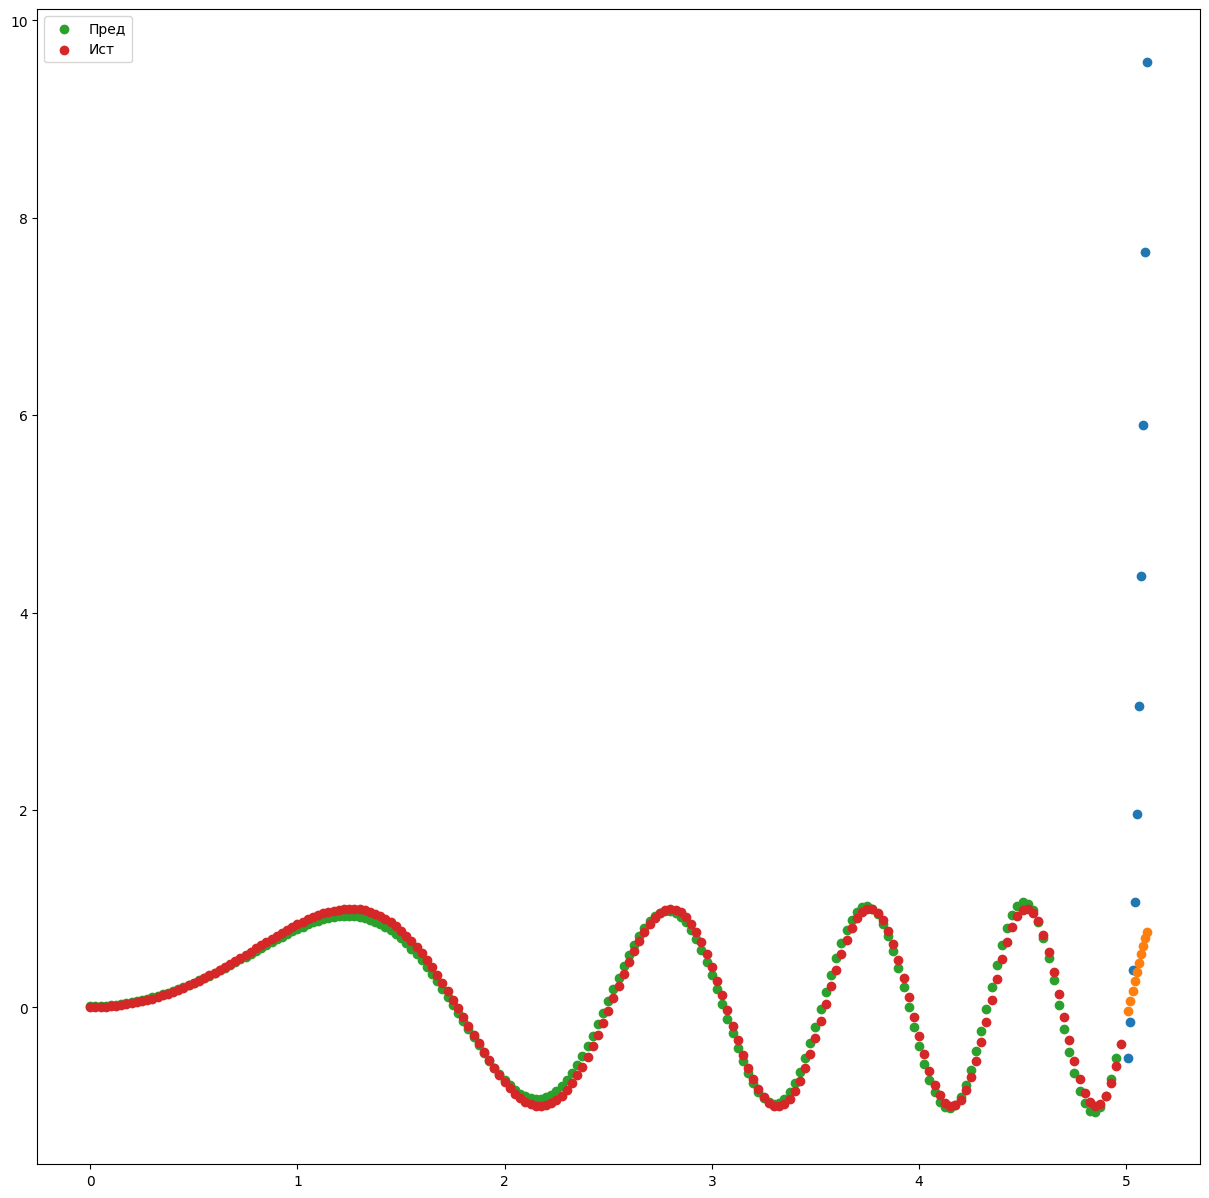

In [16]:
# Правило Правило Уидроу-Хоффа
new_time = np.array([5 + i/100 for i in range(1,11,1)])
pred_future, y_future = get_prediction(model, 10, x_1, 3), fun_x_1(new_time)
plt.figure(figsize=(15,15))
plt.scatter(new_time,pred_future)
plt.scatter(new_time,y_future)
plt.scatter(t_1[:-1],pred,label='Пред')
plt.scatter(t_1,x_1,label='Ист')
plt.legend()

In [17]:
metrics(y, pred)

r2_score =  0.9923063407054831
mean_squared_error =  0.0034461471905661
RMSE =  0.05870389416866738
Относительная СКО =  0.0587038877771121
mean_absolute_error =  0.048942742942313336
min absolute error =  2.379427484650032e-05
max absolute error =  0.141512400962775


In [18]:
print('Ошибка для правила Уидроу-Хоффа',np.sqrt(mean_squared_error(y,pred)))

Ошибка для правила Уидроу-Хоффа 0.05870389416866738


##### Прогнозирование выполнено качественно.

### Пункт 3
- Использовать линейную нейронную сеть в качестве адаптивного фильтра для подавления помех. Для настройки весовых коэффициентов использовать метод наименьших квадратов

In [19]:
# Подготовка выборки
def prepare_sample(x, y, D, ):
    back_x = []
    back_y = []


    x = [0 for i in range(D)] + list(x)
    y = [0 for i in range(D)] + list(y)


    for i in range(0,len(x)-D,1):

        back_x.append(x[i:i+D])
        back_y.append(y[i+D])

    back_x = torch.tensor(back_x)
    return back_x, back_y

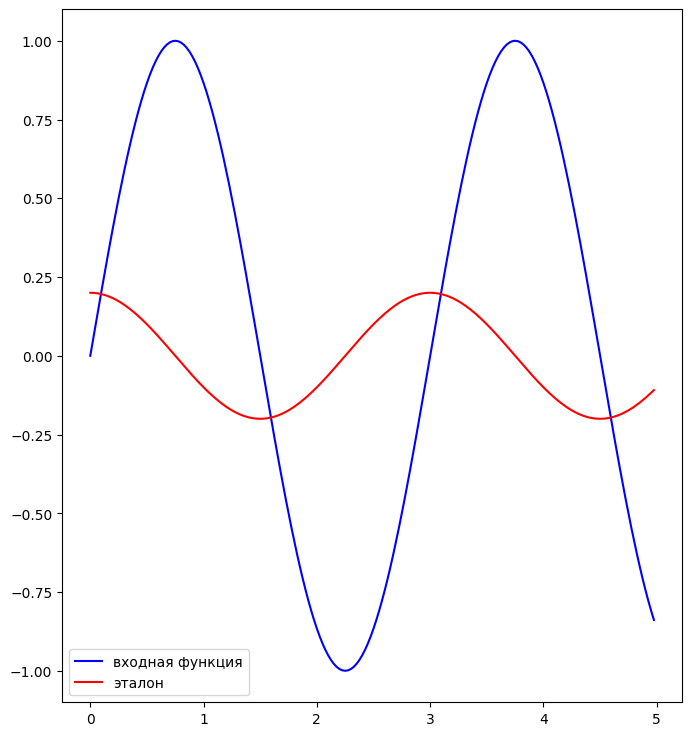

In [20]:
plt.figure(figsize=(8,9))
plt.plot(t_2,x_2,'b',label='входная функция')
plt.plot(t_2,y_2,'r',label='эталон')
plt.legend()

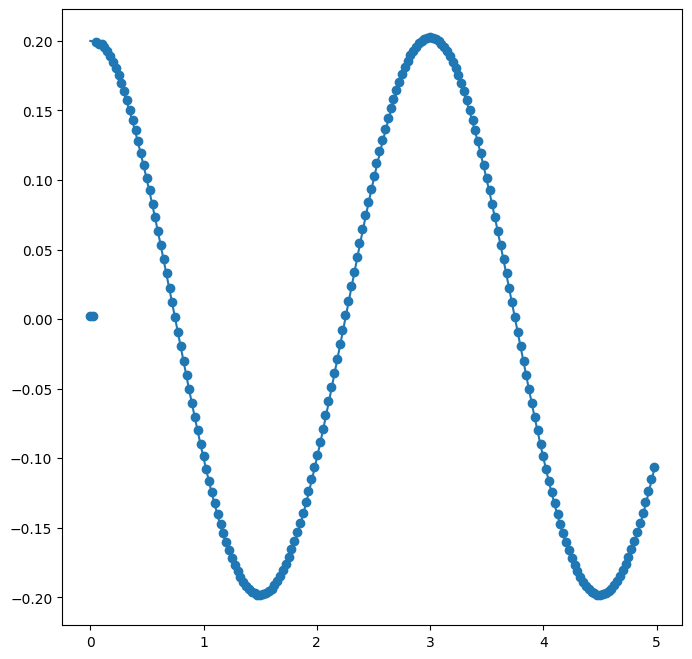

In [21]:
# МНК
def MNK(x, y, D):

    model = Net(D=D)
    x, y = prepare_sample(x, y, D)

    lstsq_x = []
    for i in x:
        lstsq_x.append([1] + list(i))
    back = np.linalg.lstsq(lstsq_x,y)
    dict_of_weights = model.state_dict()
    dict_of_weights['fc1.weight'] = torch.tensor(back[0][1:]).reshape((1,4))
    dict_of_weights['fc1.bias'] = torch.tensor([back[0][0]])
    model.load_state_dict(dict_of_weights, strict=False)
    prediction = [float(i) for i in model(torch.tensor(x).float()).detach().numpy()]
    return model, prediction, y

model, pred, y = MNK(x_2, y_2, 4)
plt.figure(figsize=(8,8))
plt.scatter(t_2,pred)
plt.plot(t_2,y)



In [22]:
metrics(y, pred)

r2_score =  0.9808675303213931
mean_squared_error =  0.00039512446946053724
RMSE =  0.01987773803682243
Относительная СКО =  0.01987773803681873
mean_absolute_error =  0.00395396428459111
min absolute error =  1.1286387102682482e-09
max absolute error =  0.19783465475775303


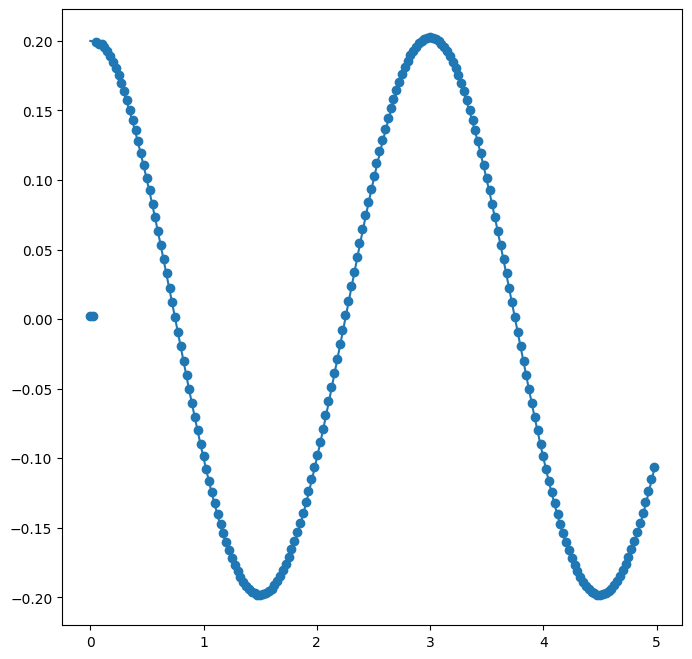

In [23]:
# Псевдоинверсное правило
model, error_psevdo, pred, x, y = train_model_psevda(x_2, y_2, 4)
plt.figure(figsize=(8,8))
plt.scatter(t_2,pred)
plt.plot(t_2,y)



In [25]:
metrics(y, pred.reshape(-1))

r2_score =  0.9808675303213931
mean_squared_error =  0.00039512446946053724
RMSE =  0.01987773803682243
Относительная СКО =  0.01987773803681873
mean_absolute_error =  0.00395396428459111
min absolute error =  1.1286387102682482e-09
max absolute error =  0.19783465475775303
